In [1]:
import os, sys, re
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# библиотека для расчетов метрик
from sklearn import metrics

# библиотека модели линейной регрессии
from sklearn import linear_model

# библиотека модели ансамблей
from sklearn import ensemble

# библиотека для разделения датасета
from sklearn import model_selection

# для обработки timestamp в формате utc
from datetime import datetime

# выводить все результаты вычислений в ячейках Code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# скрытие сообщений об ошибках при обработке ответов
import warnings
# игнорируем предупреждения
warnings.filterwarnings('ignore')

# подключить сборщик "мусора"
import gc

# from pandas_datareader import DataReader
# import pandas_datareader.data as pdr

# библиотека моделей ARIMA
from statsmodels.tsa.arima import model

# библиотека построения коррелограмм
from statsmodels.graphics import tsaplots

# тесты (тест Дики-Фуллера)
from statsmodels.tsa import stattools

# библиотека импорта котировок с агрегатора Yahoo Finance
import yfinance as yf

# библиотека экспорта модели в бинарном состоянии
import pickle

# библиотека Prophet
from prophet import Prophet

# библиотека catboost
import catboost as cb
from catboost import utils

# изменить формат вывода pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.set_option('display.max_info_rows', 500)
# pd.set_option('display.max_info_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.large_repr', 'truncate')

In [2]:
# КОНСТАНТЫ
SRC_SUBFOLDER = './.'

# формируем относительный системный путь для импорта файлов с функциями
# если SRC_SUBFOLDER = './.' + './', получим относительный путь './../'
sys.path.append(os.path.relpath(SRC_SUBFOLDER + './'))

# импортируем внешние константы
from src.constants import *

# импортируем собственные функции
from src.funcs_1 import *
from src.funcs_2 import *

# 1. Загрузка данных

Установим предельный срок в 5 лет для акций с интервалом котирования в 1 день, сформируем временнЫе границы для данных:

In [3]:
# предельный срок выгрузки (5 лет)
year_period = 5

# начальные и конечные сроки выгрузки
current = datetime.date(datetime.now())
start = datetime(current.year - year_period, current.month, current.day).strftime("%Y-%m-%d")
end = datetime(current.year, current.month, current.day).strftime("%Y-%m-%d")

# выводим результат
print(current)
print(start)
print(end)

2023-08-29
2018-08-29
2023-08-29


Загружаем котировки 4 интернациональных гигантов - **[Apple](https://finance.yahoo.com/quote/AAPL/history?p=AAPL)**, **[Microsoft](https://finance.yahoo.com/quote/MSFT/history?p=MSFT)**, **[Google]()**, **[nVidia](https://finance.yahoo.com/quote/NVDA/history?p=NVDA)**. Котировки ежедневные, глубиной 5 лет.

Соединяем все данные в один массив для удобства:

In [5]:
# будем анализировать фантастическую четвёрку
tick_list = ['AAPL', 'MSFT', 'GOOG', 'NVDA']

# исходный пустой датафрейм
df = pd.DataFrame()

# загружаем данные, объединяем котировки в один датафрейм
for tick in tick_list:
    df = pd.concat([df, yf.download(tick, start=start, end=end, period=str(year_period) + 'y', interval='1d')['Close']], axis=1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## 1.1 Предобработка данных

In [6]:
# переименовываем признаки, т.к. они имеют одинаковое имя интересующего признака - 'Close'
df.columns = ['Close' + str(col[0]) if col[1] == 'Close' else col[1] for col in enumerate(df.columns)]

# переименовываем признаки, в соответствии с загруженными данными
df.rename(columns=dict(zip(df.columns.to_list(), tick_list)), inplace=True)

# выводим результат
df

,AAPL,MSFT,GOOG,NVDA
2018-08-29,55.744999,112.019997,62.465000,69.622498
2018-08-30,56.257500,111.949997,61.956001,69.452499
2018-08-31,56.907501,112.330002,60.909500,70.169998
2018-09-04,57.090000,111.709999,59.849998,70.925003
2018-09-05,56.717499,108.489998,59.324001,69.605003
...,...,...,...,...
2023-08-22,177.229996,322.459991,129.690002,456.679993
2023-08-23,181.119995,327.000000,133.210007,471.160004
2023-08-24,176.380005,319.970001,130.419998,471.630005
2023-08-25,178.610001,322.980011,130.690002,460.179993


## 1.2 Формирование Time Series

В связи с тем, что тип *DatetimeIndex* при подгрузке данных не присваивается, а требуется работать именно с ним, по умолчанию имеет тип *'object'*, следует обозначить, что нам требуются данные в виде **Time Series** (т.н. *"временнЫе ряды"*):

In [9]:
# преобразуем столбец индексных меток к временнОму типу
df.index = pd.DatetimeIndex(df.index.values)

# выводим результат
df
df.index

,AAPL,MSFT,GOOG,NVDA
2018-08-29,55.744999,112.019997,62.465000,69.622498
2018-08-30,56.257500,111.949997,61.956001,69.452499
2018-08-31,56.907501,112.330002,60.909500,70.169998
2018-09-04,57.090000,111.709999,59.849998,70.925003
2018-09-05,56.717499,108.489998,59.324001,69.605003
...,...,...,...,...
2023-08-22,177.229996,322.459991,129.690002,456.679993
2023-08-23,181.119995,327.000000,133.210007,471.160004
2023-08-24,176.380005,319.970001,130.419998,471.630005
2023-08-25,178.610001,322.980011,130.690002,460.179993


DatetimeIndex(['2018-08-29', '2018-08-30', '2018-08-31', '2018-09-04',
               '2018-09-05', '2018-09-06', '2018-09-07', '2018-09-10',
               '2018-09-11', '2018-09-12',
               ...
               '2023-08-15', '2023-08-16', '2023-08-17', '2023-08-18',
               '2023-08-21', '2023-08-22', '2023-08-23', '2023-08-24',
               '2023-08-25', '2023-08-28'],
              dtype='datetime64[ns]', length=1257, freq=None)

## 1.3 Интерполяция *NaN*-значений

Тип индексов обозначен, но не имеет конкретного типа *freq=None*, чтобы это устранить, надо выполнить операцию приведения типа через **asfreq()**  или **[resample()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html?highlight=resample#pandas.DataFrame.resample)** с указанием типа *'D'*, т.е. каждая метка - это событие за 1 день. При преобразовании получим, что все данные у нас - ежедневные.

В связи с тем, что биржевые котировки акций торгуются только в рабочие дни, т.н. *business days*, то данные по субботам и воскресеньям будут отсутствовать, т.е. приведёт при **upsampling**'е к появлению пустых (*NaN*) значений, заполним их методом **[ffill()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ffill.html?highlight=ffill#pandas.DataFrame.ffill)**, заполнять будем первым непустым значением с помощью **[first()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.first.html?highlight=first#pandas.DataFrame.first)**:

In [10]:
# выполняем upsampling до '1D' и заполняем NaN-значения со сдвигом вперёд
df = df.resample('D').first().ffill()

# выводим результат
df
df.index

,AAPL,MSFT,GOOG,NVDA
2018-08-29,55.744999,112.019997,62.465000,69.622498
2018-08-30,56.257500,111.949997,61.956001,69.452499
2018-08-31,56.907501,112.330002,60.909500,70.169998
2018-09-01,56.907501,112.330002,60.909500,70.169998
2018-09-02,56.907501,112.330002,60.909500,70.169998
...,...,...,...,...
2023-08-24,176.380005,319.970001,130.419998,471.630005
2023-08-25,178.610001,322.980011,130.690002,460.179993
2023-08-26,178.610001,322.980011,130.690002,460.179993
2023-08-27,178.610001,322.980011,130.690002,460.179993


DatetimeIndex(['2018-08-29', '2018-08-30', '2018-08-31', '2018-09-01',
               '2018-09-02', '2018-09-03', '2018-09-04', '2018-09-05',
               '2018-09-06', '2018-09-07',
               ...
               '2023-08-19', '2023-08-20', '2023-08-21', '2023-08-22',
               '2023-08-23', '2023-08-24', '2023-08-25', '2023-08-26',
               '2023-08-27', '2023-08-28'],
              dtype='datetime64[ns]', length=1826, freq='D')

In [11]:
# проверяем пустые значения
df.isna().sum()

AAPL    0
MSFT    0
GOOG    0
NVDA    0
dtype: int64

---

# 2. EDA

## 2.1 Общий анализ

Взглянем на общую картину, что из себя представляют данные:

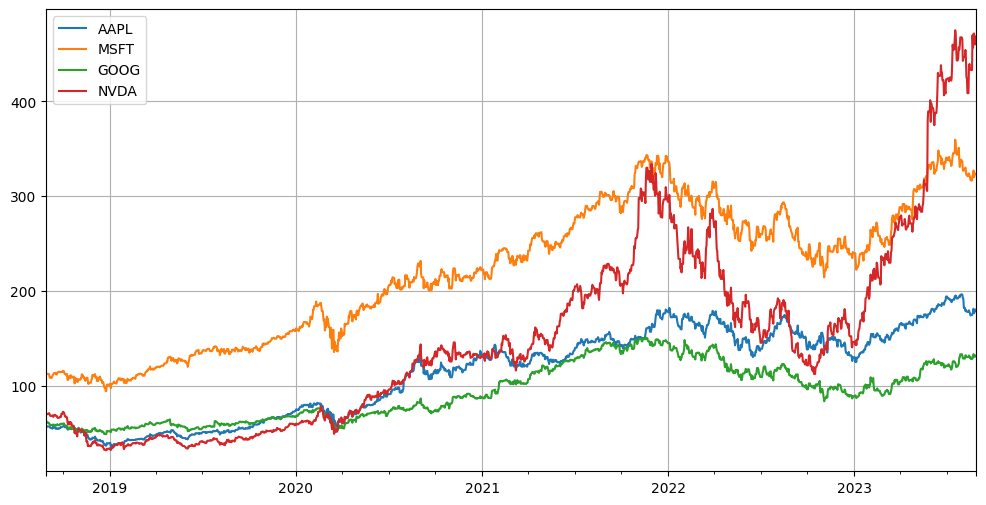

In [13]:
plt.rcParams['figure.figsize'] = 12, 6
df.plot()
plt.grid();

Общая картина по акциям показывает, что они все принадлежит разным корпорациям, есть общие синхронные пики и провалы, скорее всего, это какие-то глобальные события, которые влияют независимо от расположения, например, мировое событие по COVID-19, явно, видно на графике - кратковременный провал на период весны 2020, 2022 год шёл под знаменем майнинга, отсюда и затяжное пике у nVidia и остальных.

На графике выше ↑ видно, что тренд возрастающий на всем протяжении, приблизительно, с середины 2020 года значительный рост у Microsoft & nVidia.

Падение в 2022 году может быть связано с известными событиями 2022 года (СВО), многие компании завершили свою деятельность в России, что не может не вызывать сожаление, и как закономерное следствие - соответствующее падение стоимости. Кто бы что, не говорил, но рынок РФ, весьма, немаленький, понятно, что многие компании зависят от санкций и ограничений, ну что поделать, их выбор и обстоятельства.

Видно, что все крупные корпорации, немного, но зависят друг от друга.

## 2.2 Корреляция данных

Посмотрим на парные графики корреляций:

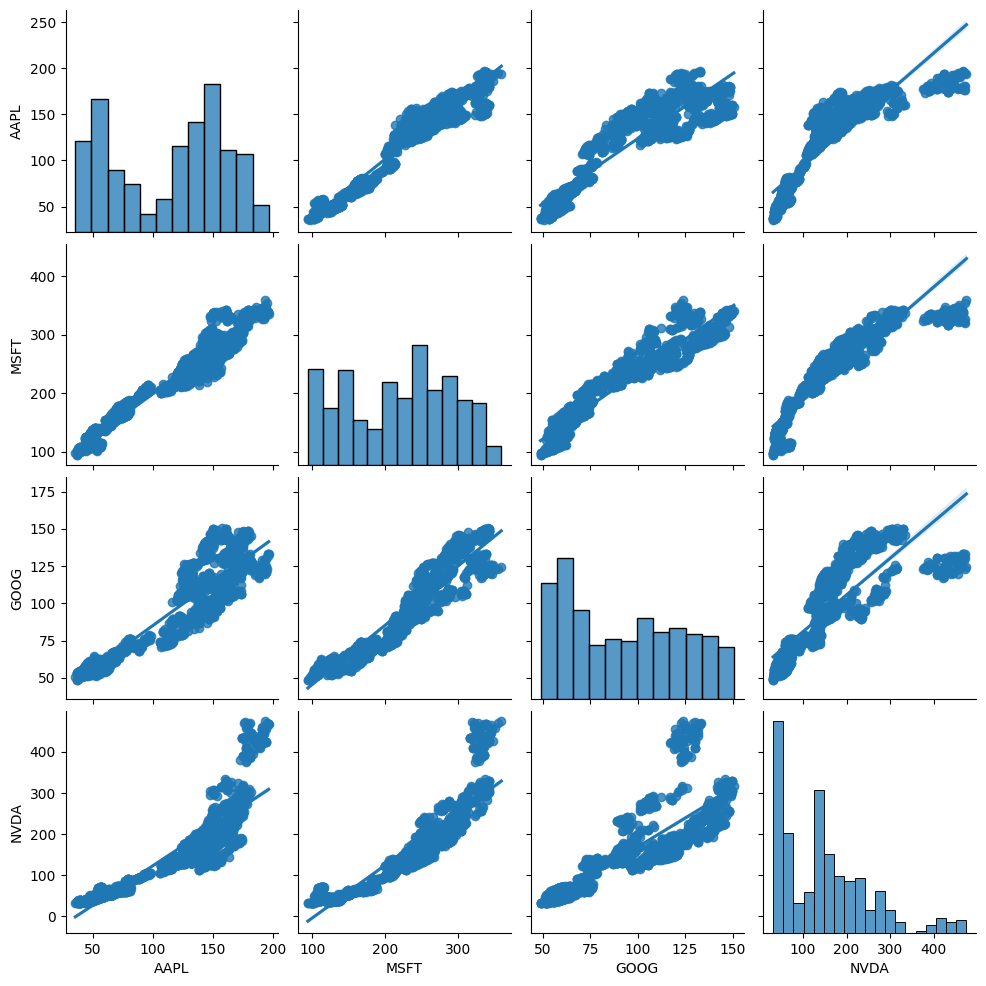

In [15]:
sns.pairplot(df, kind='reg');

График наглядно отображает зависимость одной компании от соседа - точки располагаются на восходящей прямой.

Посмотрим тепловую карту:

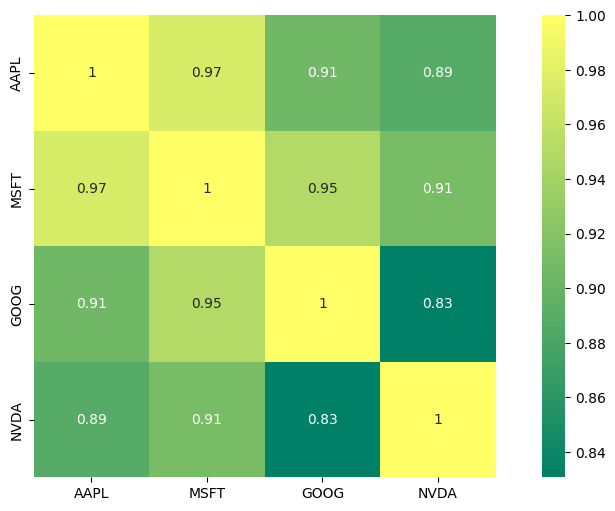

In [16]:
sns.heatmap(
    df.corr(), 
    annot=True, 
    square=True, 
    cmap='summer'
);

Тепловая карта подтверждает выводы, сделанные ранее.

### **Выводы:**

* Все инфо-гиганты зависят друг от друга и эффективность ведения совместных договоренностей приводит к росту обеих и каждого.

* Мировые события синхронно сказываются на стоимости акций всех компаний одной отрасли.

## 2.3 Исследование ряда

Выберем одну котировку для наглядного исследования, остальные котировки будут подвергнуты идентичным шагам построения моделей, повторять и дублировать исследования в виде графиков и вычислений не буду, в целях краткости и наглядности, данные по остальным котировкам будут сведены в итоговую сравнительную таблицу и представлены в разделе 4 - "Результаты, выводы".

In [17]:
# выбираем котировку GOOG
data = pd.DataFrame(df[df.columns[2]])

# выводим результат
data.head(1)

,GOOG
2018-08-29,62.465


### 2.3.1 Оценка наличия тренда и сезонности ряда

Посмотрим на тренд и сезонность поближе:

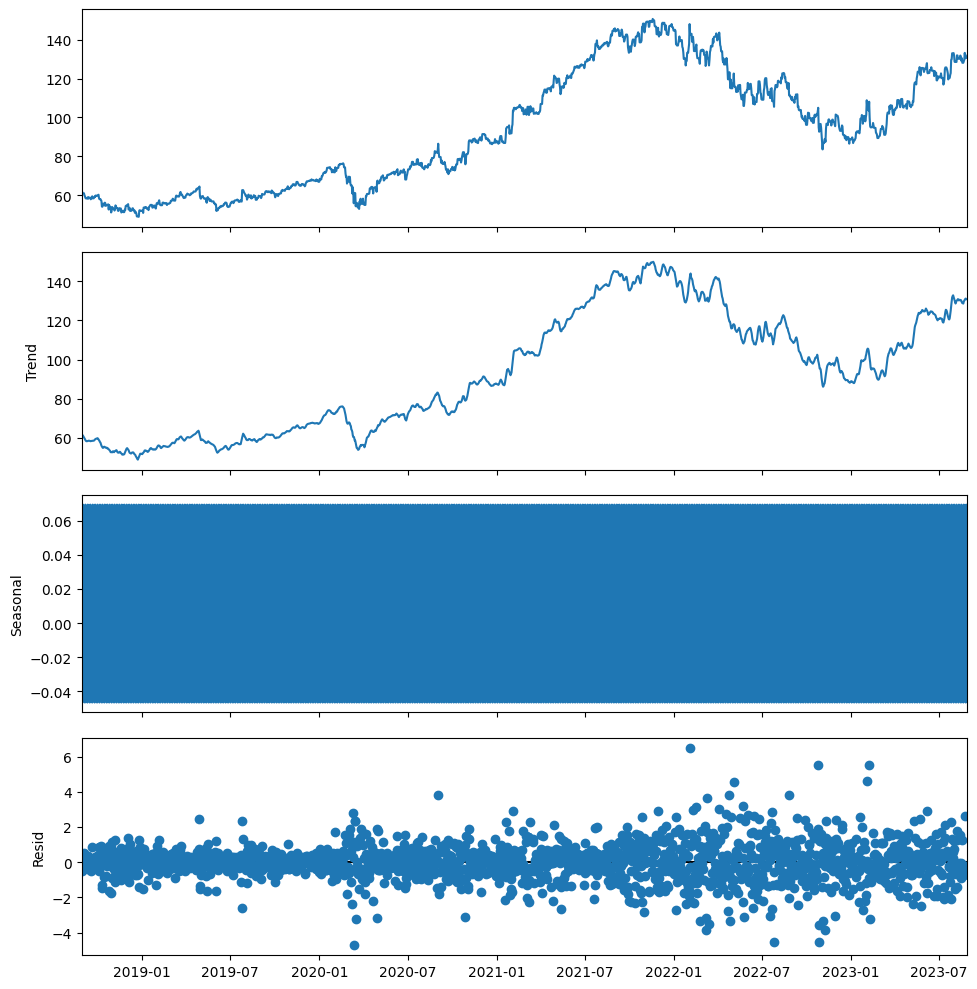

In [18]:
# декомпозиция временного ряда
from statsmodels.tsa import seasonal

# библиотека построения коррелограмм
from statsmodels.graphics import tsaplots

plt.rcParams['figure.figsize'] = 10, 10

# производим декомпозицию временного ряда
decomposition = seasonal.seasonal_decompose(data, period=5)
decomposition.plot();

Визуально тренд совпадает со значениями, график сезонности не проясняет картину, но, она, наверняка, есть, т.к. данные о котировках, мы знаем что они меняется каждые 5 дней (рабочих дней, т.н. *'business days'*).

Посмотрим на график сезонности ещё поближе, выберем последние 50 значений и мы видим явную сезонность с "окном" в 5 дней ↓:

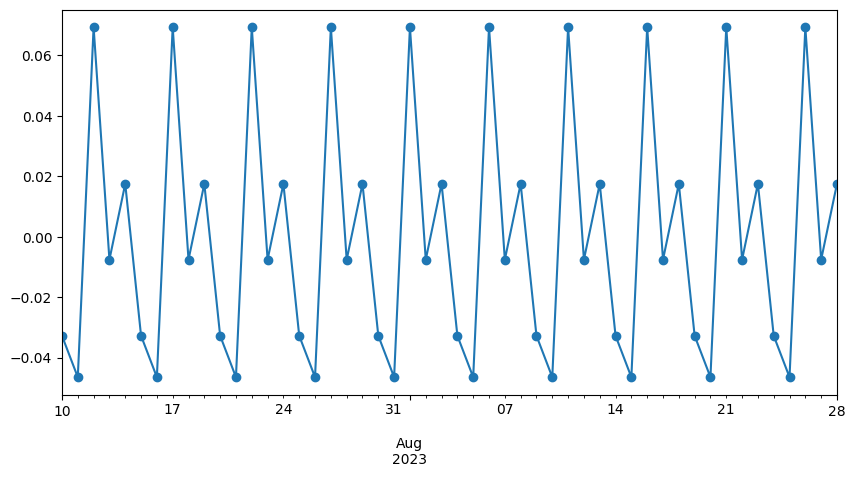

In [19]:
plt.rcParams['figure.figsize'] = 10, 5
decomposition.seasonal[-50:].plot(marker='o');

### **Выводы:**

Предварительная оценка, при анализе ряда наблюдается:

* тренд;
* наличие сезонности;
* присутствие шума, остатки сосредоточены близко 0.

---

### 2.3.2 Разбиение данных

Разобъём данные на тренировочную и тестовые выборки - окна в 90 дней (5 % на тестовые данные) должно хватить на валидацию при имеющихся более 1500 записей:

In [20]:
# разбиение выборки
train_df, test_df = split_data(data, SPLIT_SIZE)

# выводим результат
print(f'Размерность тренировочной выборки: {train_df.shape}')
print(f'Размерность тестовой выборки: {test_df.shape}')

Размерность тренировочной выборки: (1735, 1)
Размерность тестовой выборки: (91, 1)


In [21]:
# выводим результат
test_df

,GOOG
2023-05-30,124.639999
2023-05-31,123.370003
2023-06-01,124.370003
2023-06-02,125.230003
2023-06-03,125.230003
...,...
2023-08-24,130.419998
2023-08-25,130.690002
2023-08-26,130.690002
2023-08-27,130.690002


### 2.3.3 Оценка стационарности ряда, выбор модели для временного ряда

Построим коррелограммы, чтобы оценить корреляцию (убедиться в этом снова).

Коррелограммы в 50 лагов показывают, что исходный ряд сильно скоррелирован ↓:

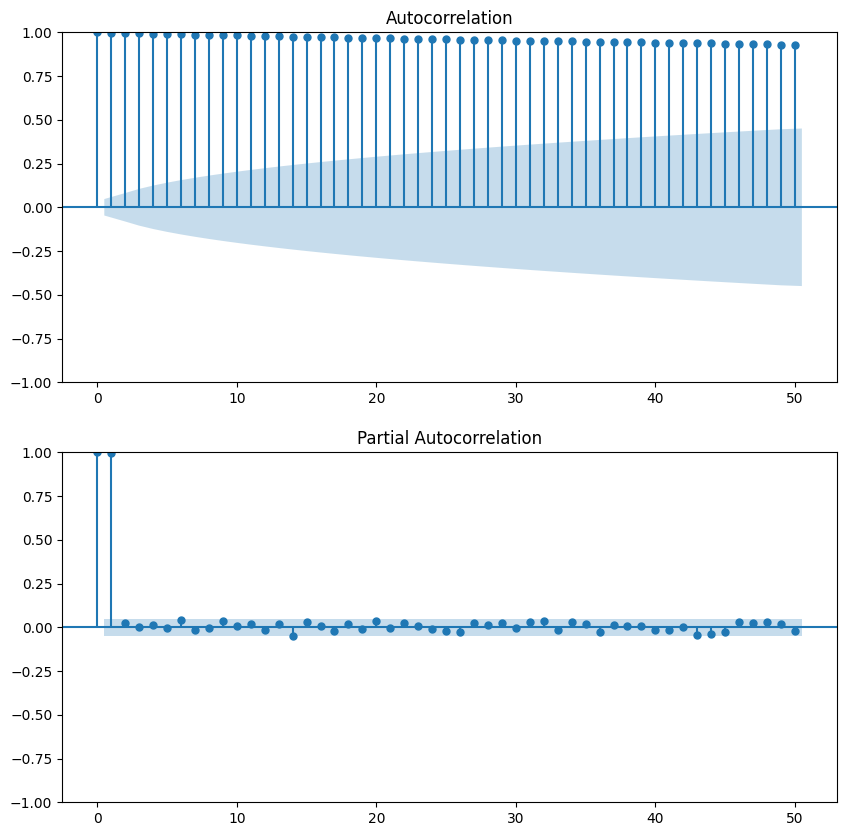

In [22]:
get_correlograms(train_df, 50)

Оценим стационарность ряда с помощью функции `get_adfuller_test` (тест Дики-Фуллера):

In [23]:
# проверяем ряд на стационарность
get_adfuller_test(train_df, 2)

ADF Statistic: -0.9519107730956036
p-value: 0.7703974312529673
Critical Values: {'1%': -3.434155392475539, '5%': -2.8632208679350253, '10%': -2.567664847292613}
При пороге '5%' есть единичные корни, ряд НЕ стационарен


In [24]:
# проверяем ряд на стационарность, интегрированный ряд 1-го порядка
get_adfuller_test(train_df.diff().dropna(), 2)

ADF Statistic: -11.398589881774043
p-value: 7.747915656226002e-21
Critical Values: {'1%': -3.434155392475539, '5%': -2.8632208679350253, '10%': -2.567664847292613}
При пороге '5%' единичных корней нет, ряд СТАЦИОНАРЕН


Интегрированный ряд 1-го порядка ряд стал стационарным, принимаем $d = 1$, т.к. ряд нестационарный и не требуется учитывать экзогенные переменные, то можно применить модель *SARIMA*, в связи с наличием сезонности.

Посмотрим на коррелограммы:

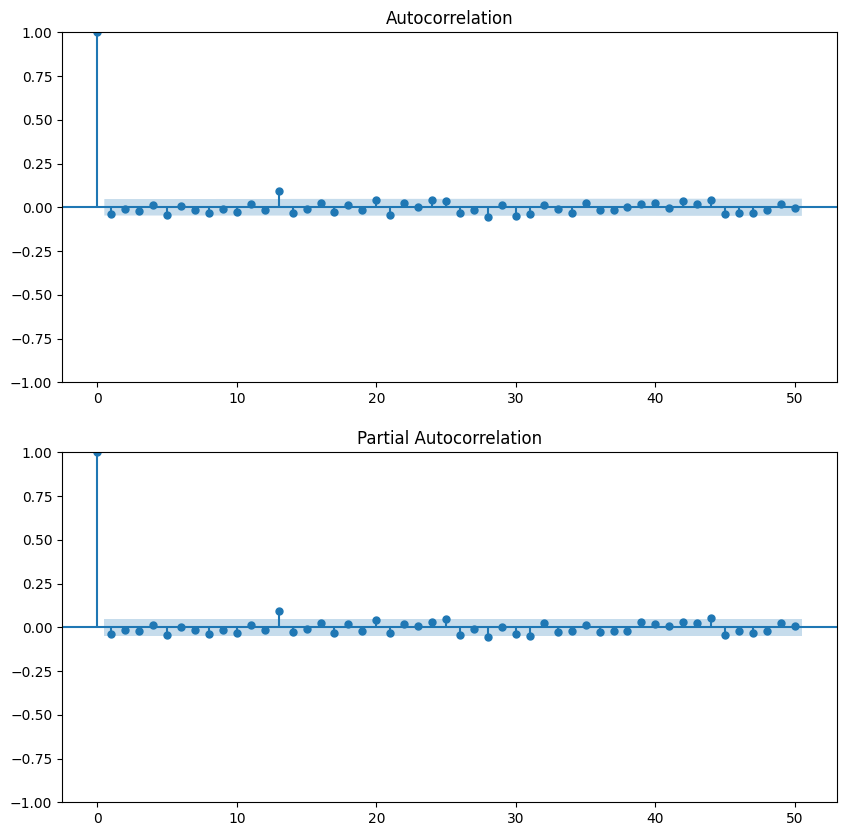

In [25]:
get_correlograms(train_df.diff().dropna(), 50)

На основании графиков автокорреляции и частичной автокорреляции выбираем параметры для модели:

* $p = 1$,
* $q = 1$.

### **Выводы:**

Предварительные параметры для SARIMA-модели:

* $p = 1$,
* $d = 1$, 
* $q = 1$.

Приступим к построению моделей.

---

# 3. Моделирование

## 3.1 Baseline. Модель SMA (простое скользящее среднее)

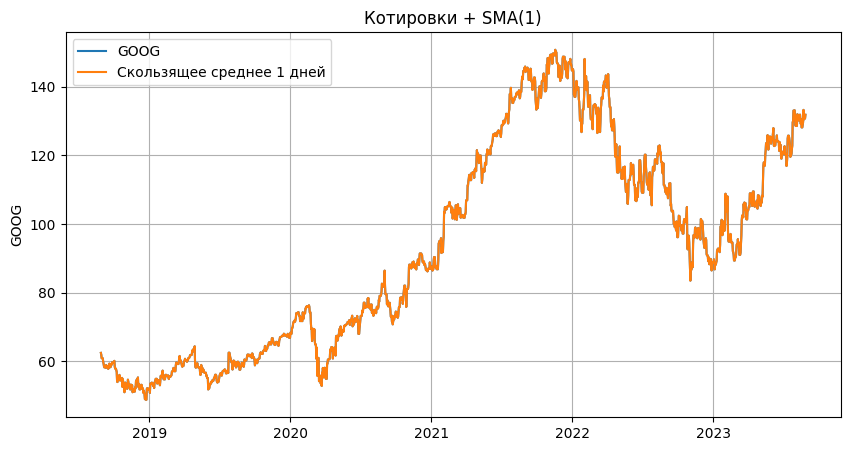

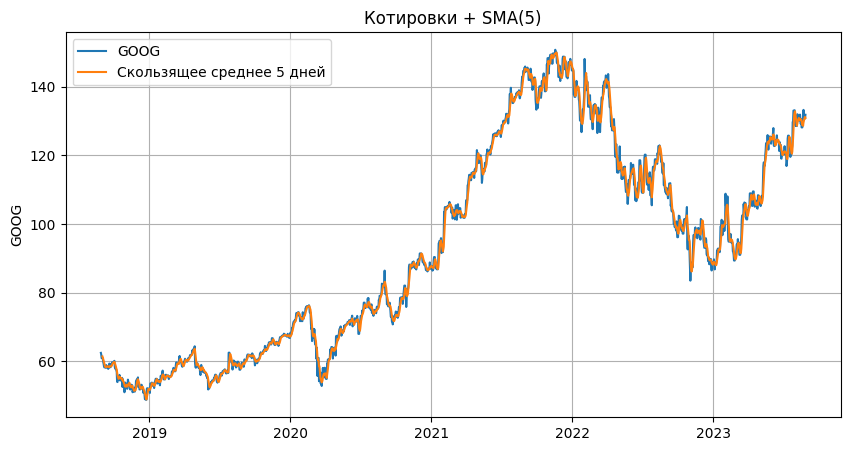

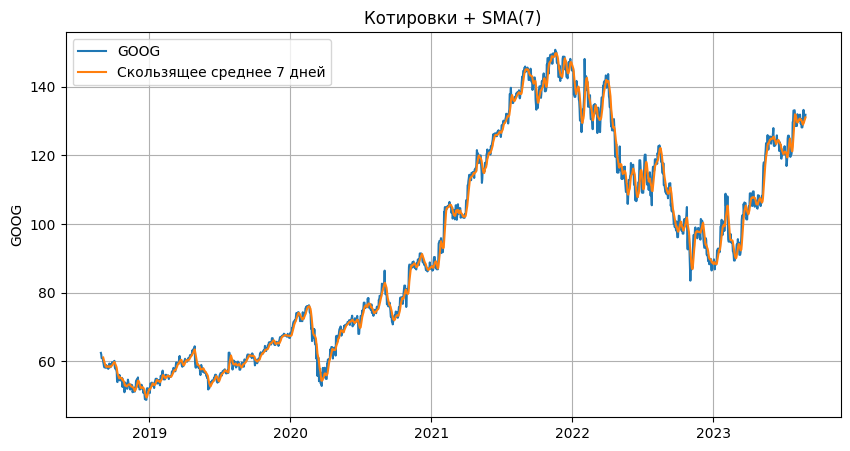

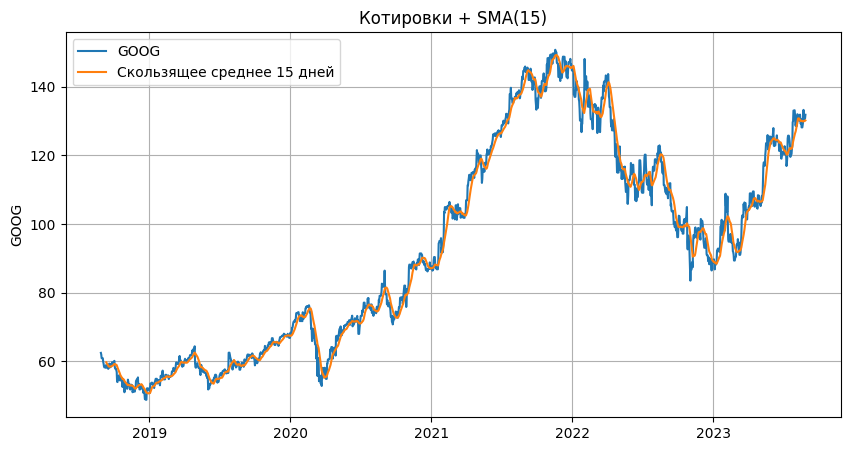

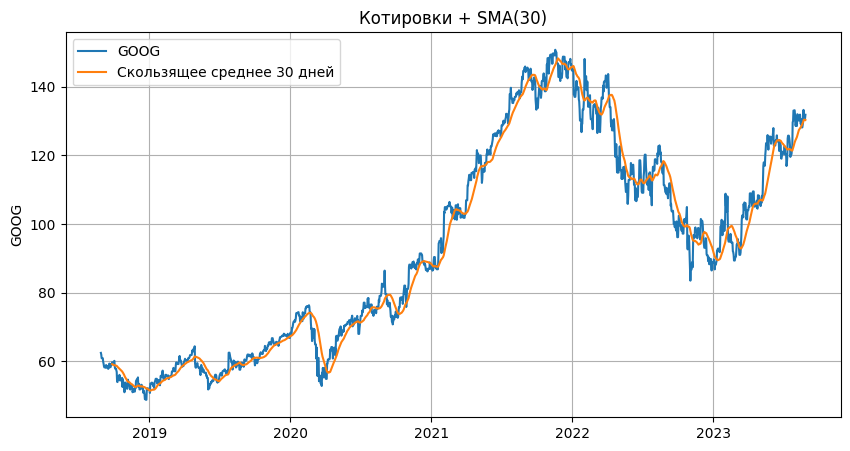

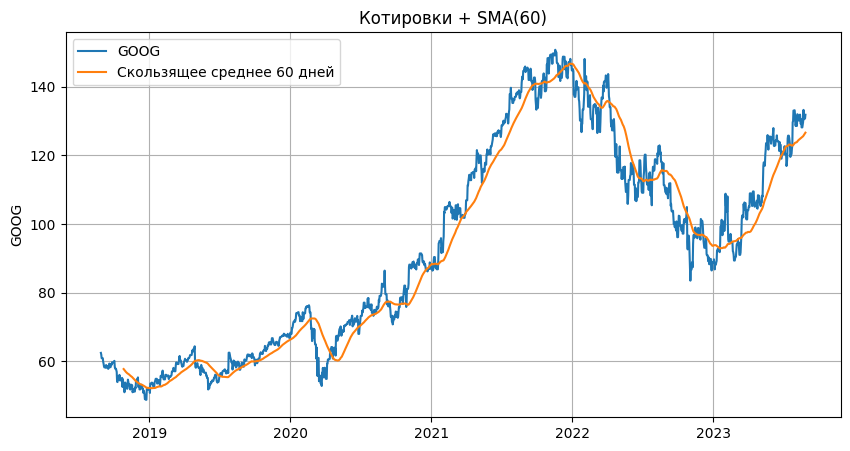

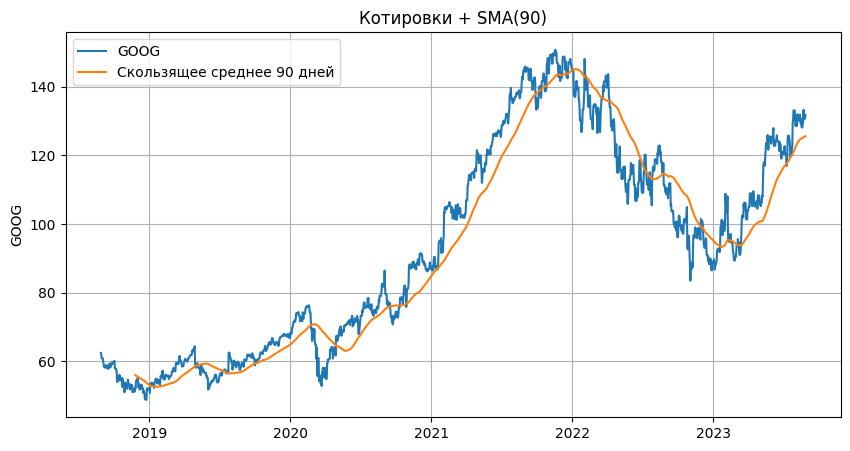

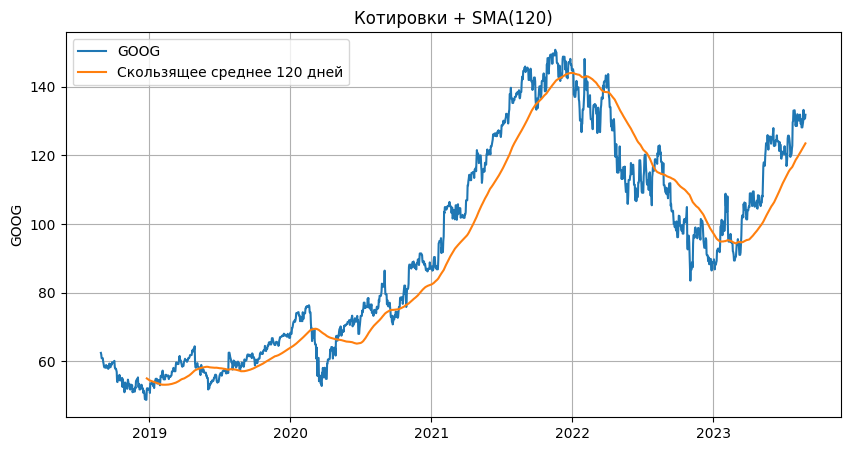

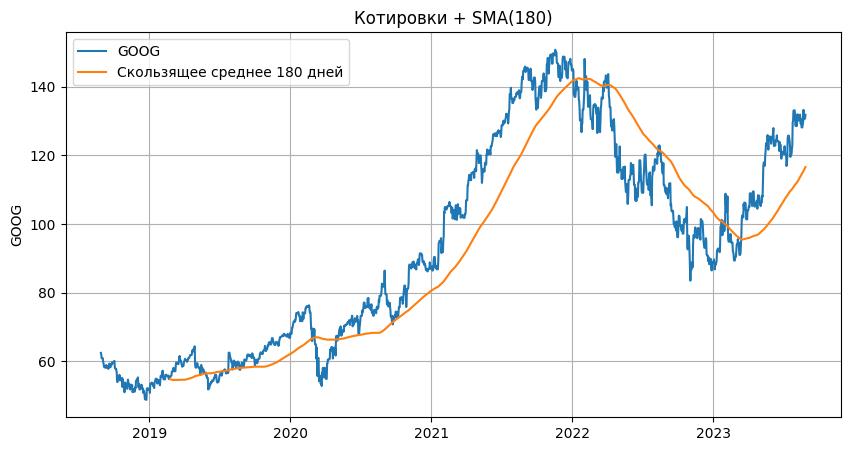

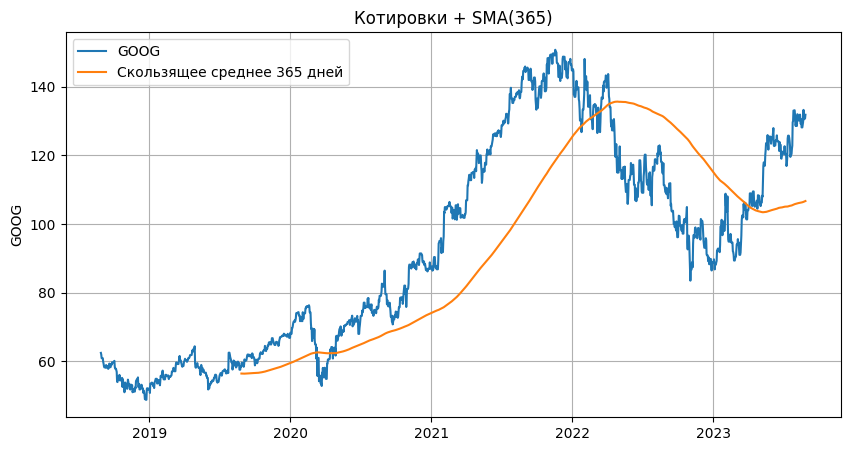

In [26]:
# строим SMA с окнами в диапазоне от 1 до 365, включительно
for i in [1, 5, 7, 15, 30, 60, 90, 120, 180, 365]:
    # задаём полотно
    fig, ax_line = plt.subplots(figsize=(10, 5))
    
    # строим график основных данных
    ax_line = sns.lineplot(x=data.index, y=data[data.columns[0]], label=data.columns[0])

    # строим график SMA
    ma = data.rolling(i).mean()
    ax_line = sns.lineplot(x=ma.index, y=ma[data.columns[0]], label='Скользящее среднее '  + str(i) + ' дней')
    
    # формируем заголовок и сетку
    ax_line.grid()
    _ = plt.title('Котировки + SMA(' + str(i) + ')')

Скользящее среднее помогает избавить временной ряд от выбросов и лишнего шума, это упрощает визуальный анализ, но вместе с тем, с увеличением "окна", оборотная сторона медали - приходится платить потерей данных, причем, существенно. Модель SМА с окном в 60 дней и более очень сильно сгладила график, потеряна часть данных - скачки и пики просто "срезаны", график идёт "наперерез", "съедая и срезая углы", SМА с окном в 30 дней сгладила данные максимально аккуратно, сохранив пики и переходы.

В связи с тем, что тестовая выборка составляет порядка 90 записей (91, если быть точным), то для объективности оценки, принимаем скользящее среднее с окном в 90 дней:

In [27]:
# метрики SMA(90)
get_metrics(test_df, data[data.columns[0]].rolling(90).mean().iloc[len(train_df):])

MAPE: 5.84 %
MSE: 7.28748e+01 $^2
RMSE: 8.53667e+00 $


Неплохие метрики, посмотрим, что покажут другие модели.

## 3.2 Подбор гиперпараметров для SARIMA с помощью `pmdarima`

Попробуем подобрать оптимальные гиперпараметры для модели *ARIMA*:

* Параметр $p$: в диапазоне [1-13],
* Параметр $q$: в диапазоне [1-13],
* Задаем наличие сезонности: **m = 5** и **seasonal=True**,
* Фиксируем **random_state** и **n_jobs**, чтобы результаты были без учёта стохастического влияния и с максимальной производительностью, делаем вывод расчётов **trace** и подавляем ошибки **error_action='ignore'**, **suppress_warnings=True**,
* Чтобы сократить время расчётов убираем расчёты с интерсептом: **with_intercept=False**.

In [28]:
# библиотека подбора параметров временных рядов
import pmdarima as pm

# ищем лучшие гиперпараметры для модели интерполированными значениями
AUTO_ARIMA = pm.auto_arima(
    train_df, 
    start_p=1, d=1, start_q=1,
    max_p=13, max_d=10, max_q=13, 
    start_P=1, D=1, start_Q=1, 
    max_P=13, max_D=1, max_Q=13, 
    test='adf',
    m=5, seasonal=True, 
    trace=True,
    error_action='ignore', 
    suppress_warnings=True, 
    n_jobs=-1, 
    random_state=42, 
    with_intercept=False
)

# выводим результат
AUTO_ARIMA.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=inf, Time=2.71 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=7744.013, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=7225.269, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.55 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=7741.919, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=7004.347, Time=0.23 sec
 ARIMA(1,1,0)(3,1,0)[5]             : AIC=6848.448, Time=0.34 sec
 ARIMA(1,1,0)(4,1,0)[5]             : AIC=6755.686, Time=0.61 sec
 ARIMA(1,1,0)(5,1,0)[5]             : AIC=6734.920, Time=0.78 sec
 ARIMA(1,1,0)(6,1,0)[5]             : AIC=6691.152, Time=1.32 sec
 ARIMA(1,1,0)(7,1,0)[5]             : AIC=6657.809, Time=1.69 sec
 ARIMA(1,1,0)(8,1,0)[5]             : AIC=6652.360, Time=2.63 sec
 ARIMA(1,1,0)(9,1,0)[5]             : AIC=6638.240, Time=3.12 sec
 ARIMA(1,1,0)(10,1,0)[5]             : AIC=6622.164, Time=4.55 sec
 ARIMA(1,1,0)(10,1,1)[5]             : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1735
Model:             SARIMAX(0, 1, 1)x(10, 1, [], 5)   Log Likelihood               -3299.019
Date:                             Tue, 29 Aug 2023   AIC                           6622.038
Time:                                     16:08:05   BIC                           6687.501
Sample:                                 08-29-2018   HQIC                          6646.252
                                      - 05-29-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0384      0.017     -2.207      0.027      -0.073      -0.004
ar.S.L5       -0.9531      0.018    -52.106      0.000      -0.989      -0.917
ar.S.L10      -0.8811      0.029    -30.720      0.000      -0.937      -0.825
ar.S.L15      -0.7995      0.031    -25.775      0.000      -0.860      -0.739
ar.S.L20      -0.6625      0.036    -18.442      0.000      -0.733      -0.592
ar.S.L25      -0.5252      0.037    -14.202      0.000      -0.598      -0.453
ar.S.L30      -0.4828      0.037    -12.985      0.000      -0.556      -0.410
ar.S.L35      -0.3667      0.038     -9.698      0.000      -0.441      -0.293
ar.S.L40      -0.2468      0.036     -6.861      0.000      -0.317      -0.176
ar.S.L45      -0.1944      0.028     -6.940      0.000      -0.249      -0.139
ar.S.L50      -0.1026      0.022     -4.741      0.000      -0.145      -0.060
sigma2         2.6470      0.050     53.009      0.000       2.549       2.745
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2011.58
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               4.67   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Оценим визуально модель SARIMA полученную на гиперпараметрах с помощью встроенного инструмента: 

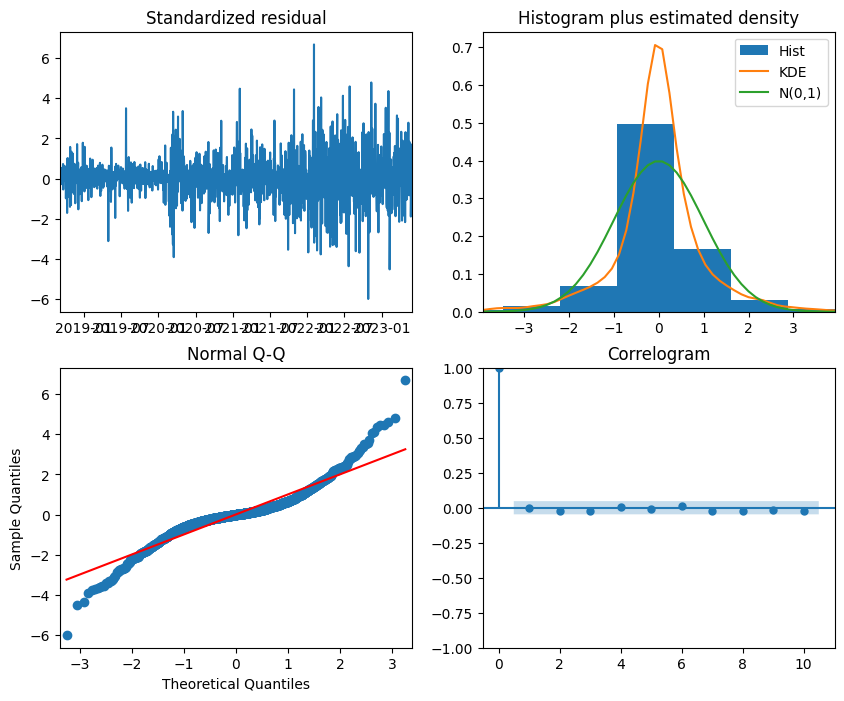

In [29]:
AUTO_ARIMA.plot_diagnostics(figsize=(10,8));

### **Выводы:**

Получены параметры для SARIMA-модели: ARIMA(0, 1, 1)(10, 1, 0, 5)

* $p = 0$,
* $d = 1$, 
* $q = 1$,
* $P = 10$,
* $D = 1$,
* $q = 0$.

Пока запомним значение метрики AIC - 6622.038

* Значения квантилей располагаются вдоль прямой,
* Остатки "поджались", если сравнивать с графиком декомпозиции,
* Коррелограмма также показывает "улучшение".

---

## 3.3 Модель SARIMA

Построим SARIMA-модель на параметрах полученных ранее "на глазок":

* $p = 1$,
* $d = 1$, 
* $q = 1$.

И сравним метрики AIC от модели SARIMA на гиперпараметрах и вручную.

In [58]:
# создаём объект класса ARIMA, обучаем модель
model_ARIMA = model.ARIMA(
    train_df, 
    enforce_stationarity=False, 
    order=(1, 1, 1), 
    seasonal_order=(1, 1, 1, 5)
)
model_ARIMA_fit = model_ARIMA.fit();

# выводим результат
model_ARIMA_fit.summary()

C:\Users\yaros\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                            GOOG   No. Observations:                 1735
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood               -3232.156
Date:                         Tue, 29 Aug 2023   AIC                           6474.312
Time:                                 16:27:19   BIC                           6501.569
Sample:                             08-29-2018   HQIC                          6484.396
                                  - 05-29-2023                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4949      0.343      1.441      0.150      -0.178       1.168
ma.L1         -0.5338      0.337     -1.584      0.113      -1.195       0.127
ar.S.L5       -0.0476      0.020     -2.428      0.015      -0.086      -0.009
ma.S.L5       -0.9943      0.005   -215.275      0.000      -1.003      -0.985
sigma2         2.4689      0.043     57.921      0.000       2.385       2.552
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2489.80
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Оценим визуально модель SARIMA построенную на параметрах подобранных вручную с помощью встроенного инструмента:

* Значения квантилей всё также располагаются вдоль прямой (хотя, визуально их немного "потянуло" незначительно в стороны от прямой),
* Остатки без изменений, если сравнивать с графиком модели на гиперпараметрах,
* Коррелограмма без изменений.

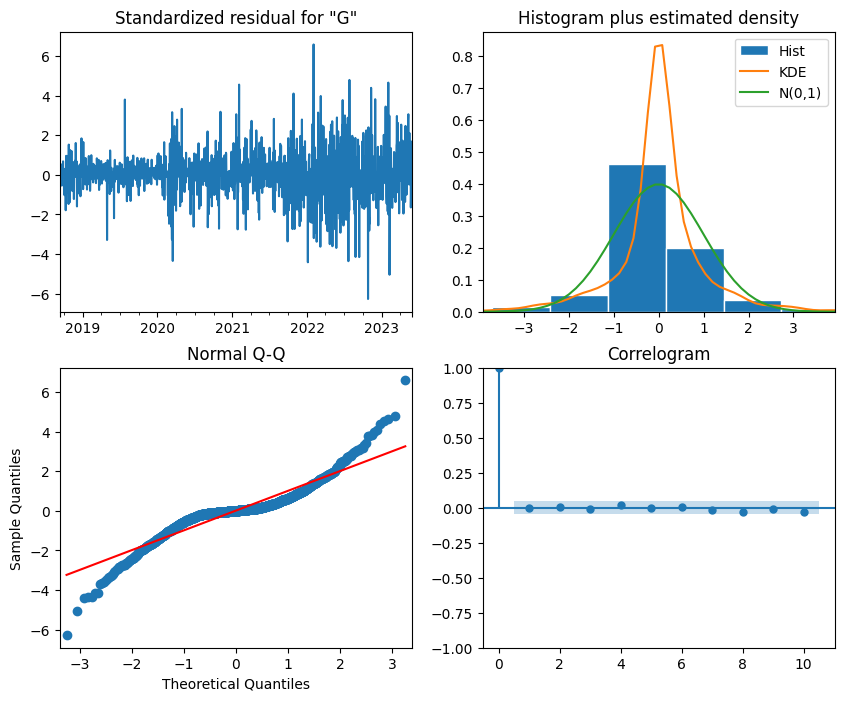

In [31]:
model_ARIMA_fit.plot_diagnostics(figsize=(10, 8));

Основываясь на ранее полученных данных, оставляем модель на параметрах вручную, от модели на гиперпараметрах отказываемся, в связи с:

* Затраченное время в 2 минуты того не стоит, т.к. метрика AIC хуже,
* Визуально отличия минимальные, можно сказать, укладывается в погрешность.

Построим предсказание модели ARIMA(1, 1, 1)x(1, 1, 1, 5):

In [32]:
# создаём отдельный датафрейм с индексами первоначального 
pred_model_ARIMA_fit = pd.DataFrame(index=data.index)

# вычисляем предсказание для тестовой выборки в новый признак 'model_preds'
pred_model_ARIMA_fit['model_preds'] = model_ARIMA_fit.predict(
    start=test_df.index[0], 
    end=test_df.index[-1]
)

# переносим истинные значения в датафрейм предсказания
pred_model_ARIMA_fit[data.columns[0]] = data[data.columns[0]]

# формируем доверительный интервал в 95%
forecast_mod = model_ARIMA_fit.get_forecast(len(test_df.index))
forecast_df_mod = forecast_mod.conf_int(alpha = 0.05)   # Confidence level of 95%

# добавляем доверительный интервал для 3 последних значений
pred_model_ARIMA_fit.at[test_df.index, 'model_preds_lower'] = forecast_df_mod[forecast_df_mod.columns[0]]
pred_model_ARIMA_fit.at[test_df.index, 'model_preds_upper'] = forecast_df_mod[forecast_df_mod.columns[1]]
pred_model_ARIMA_fit.tail()

,model_preds,GOOG,model_preds_lower,model_preds_upper
2023-08-24,128.557867,130.419998,101.892788,155.222945
2023-08-25,128.592611,130.690002,101.760929,155.424292
2023-08-26,128.782407,130.690002,101.785171,155.779643
2023-08-27,128.623444,130.690002,101.461673,155.785215
2023-08-28,128.699653,131.789993,101.372441,156.026865


Визуализируем предсказание:

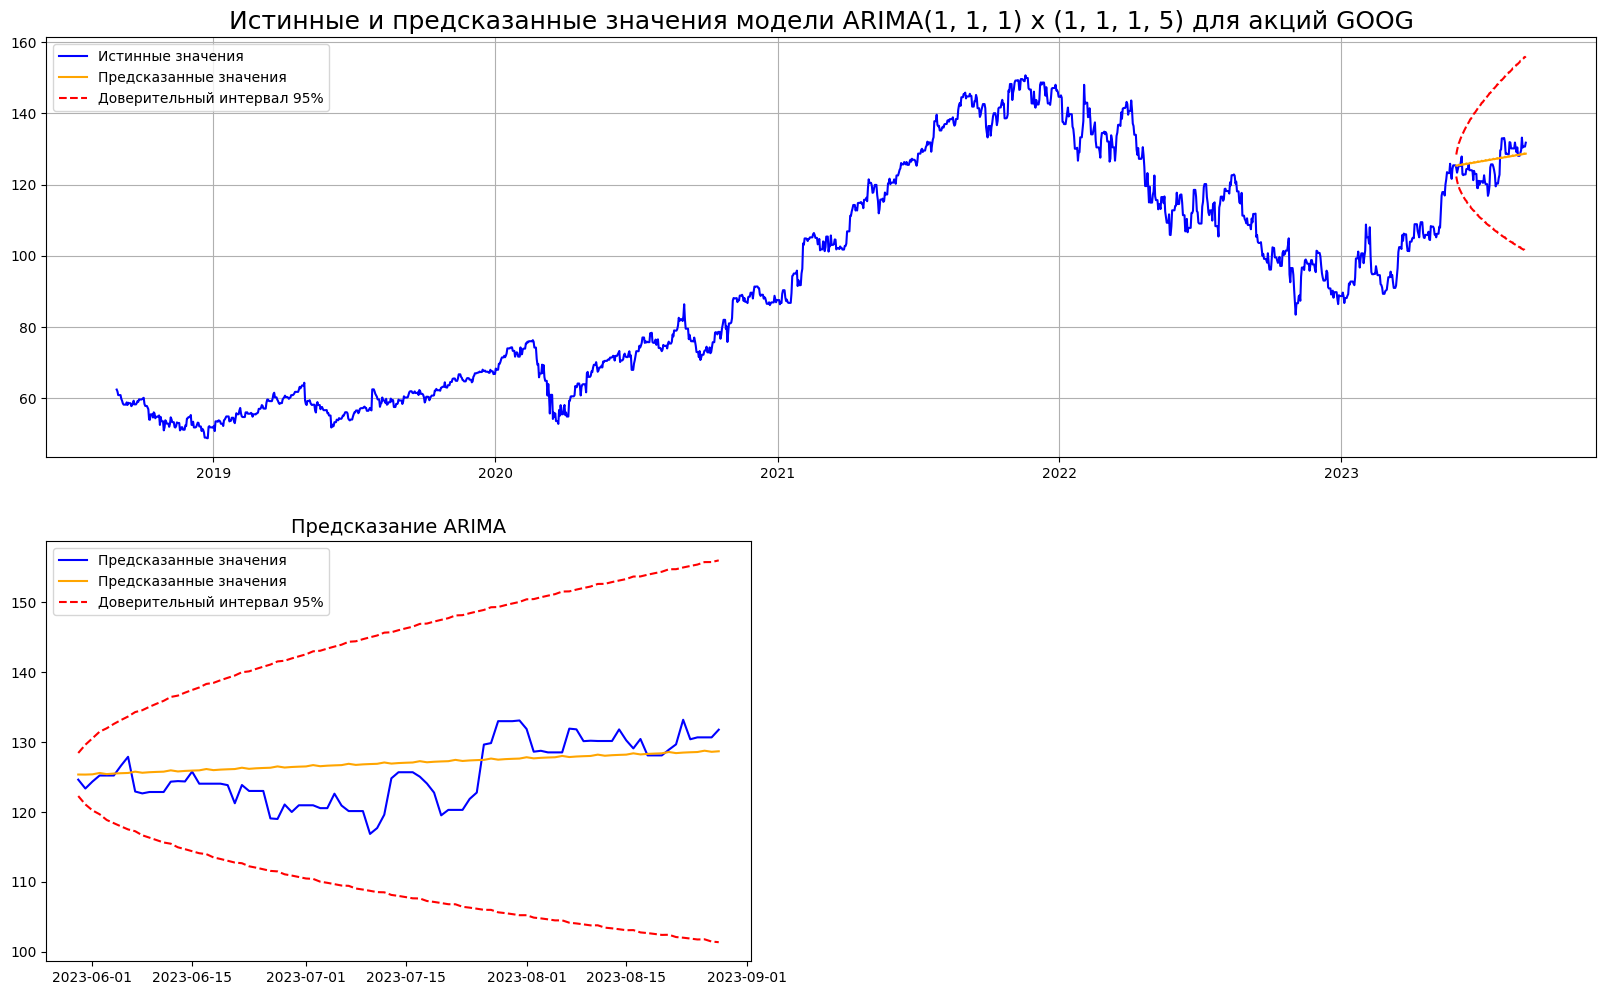

In [33]:
get_plot_time_series_predicted(
    pred_model_ARIMA_fit, test_df, 
    f"Истинные и предсказанные значения модели ARIMA" \
        f"{(model_ARIMA_fit.specification['order'])} x {(model_ARIMA_fit.specification['seasonal_order'])} " \
        f"для акций {pred_model_ARIMA_fit.columns[1]}", 
    'Предсказание ARIMA'
)

Оценим модель:

In [34]:
# метрики ARIMA
get_metrics(test_df, pred_model_ARIMA_fit['model_preds'][len(train_df):])

MAPE: 2.67 %
MSE: 1.63925e+01 $^2
RMSE: 4.04876e+00 $


### **Выводы:**

Как это ни парадоксально звучит, но оптимальные гиперпараметры, найденные алгоритмом перебора сетки значений имеют далеко неидеальную метрику AIC. Построенная навскидку модель с параметрами вручную имеет более сильную метрику AIC - 6474.312

Полученные параметры для SARIMA-модели: ARIMA(1, 1, 1)x(1, 1, 1, 5)

* $p = 1$,
* $d = 1$, 
* $q = 1$,
* $P = 1$,
* $D = 1$,
* $q = 1$.

Модель ARIMA(1, 1, 1)x(1, 1, 1, 5) с т.з. оценок метрик имеет пока лучшие метрики, они **сильно улучшены по сравнению с baseline-решением** почти на 2 раза по MAPE, более, чем в 4 раза по MSE и более, чем в 2 раза по RMSE.

---

## 3.4 Модель PROPHET

Для того, чтобы работать с моделью Prophet, данные должны быть поданы с определённой структурой конкретных признаков.

Преобразуем датасет для работы с Prophet:

In [35]:
# требуется наличие признаков ds и y
data_prophet = data.reset_index().rename(columns={'index':'ds', data.columns[0]:'y'})
data_prophet['ds'] = data_prophet['ds'].astype({'ds':'object'})
data_prophet['ds'] = data_prophet['ds'].apply(lambda x: x.strftime("%Y-%m-%d"))

Разобъём выборку в соответствии с установленной пропорцией тренировочной и тестовой выборок:

In [36]:
# разбиение выборки
train_prophet, test_prophet = split_data(data_prophet, SPLIT_SIZE)

# выводим результат
print(f'Размерность тренировочной выборки: {train_prophet.shape}')
print(f'Размерность тестовой выборки: {test_prophet.shape}')

Размерность тренировочной выборки: (1735, 2)
Размерность тестовой выборки: (91, 2)


In [37]:
# выводим результат
test_prophet

,ds,y
1735,2023-05-30,124.639999
1736,2023-05-31,123.370003
1737,2023-06-01,124.370003
1738,2023-06-02,125.230003
1739,2023-06-03,125.230003
...,...,...
1821,2023-08-24,130.419998
1822,2023-08-25,130.690002
1823,2023-08-26,130.690002
1824,2023-08-27,130.690002


Обучим модель Prophet и вычислим прогноз:

In [38]:
# задаём модель и обучаем её
prophet_model = Prophet(weekly_seasonality=True)
prophet_model.fit(train_prophet)

# вычисляем предсказание на тестовой выборке
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='D')
forecast = prophet_model.predict(future)

# формируем подвыборку тестовых предсказаний
test_forecast = forecast[-len(test_prophet):];

16:08:10 - cmdstanpy - INFO - Chain [1] start processing
16:08:10 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
# создаём отдельный датафрейм с индексами первоначального 
pred_prophet_fit = pd.DataFrame(index=data_prophet.index)

# переносим предсказание для тестовой выборки в новый признак 'model_preds'
pred_prophet_fit['model_preds'] = test_forecast['yhat']

# переносим истинные значения в датафрейм предсказания
pred_prophet_fit['Close'] = data_prophet[data_prophet.columns[1]]

# добавляем доверительный интервал для 3 последних значений
pred_prophet_fit.at[test_prophet.index, 'model_preds_lower'] = test_forecast['yhat_lower']
pred_prophet_fit.at[test_prophet.index, 'model_preds_upper'] = test_forecast['yhat_upper']

# формируем индексы как в первоначальных данных (временнЫе метки)
pred_prophet_fit.index = data.index

# выводим результат
pred_prophet_fit

,model_preds,Close,model_preds_lower,model_preds_upper
2018-08-29,NaN,62.465000,NaN,NaN
2018-08-30,NaN,61.956001,NaN,NaN
2018-08-31,NaN,60.909500,NaN,NaN
2018-09-01,NaN,60.909500,NaN,NaN
2018-09-02,NaN,60.909500,NaN,NaN
...,...,...,...,...
2023-08-24,105.461979,130.419998,97.625836,112.663130
2023-08-25,105.287687,130.690002,97.383681,112.509537
2023-08-26,105.114920,130.690002,97.337837,112.898332
2023-08-27,104.936523,130.690002,97.499030,113.013335


Визуализируем предсказание:

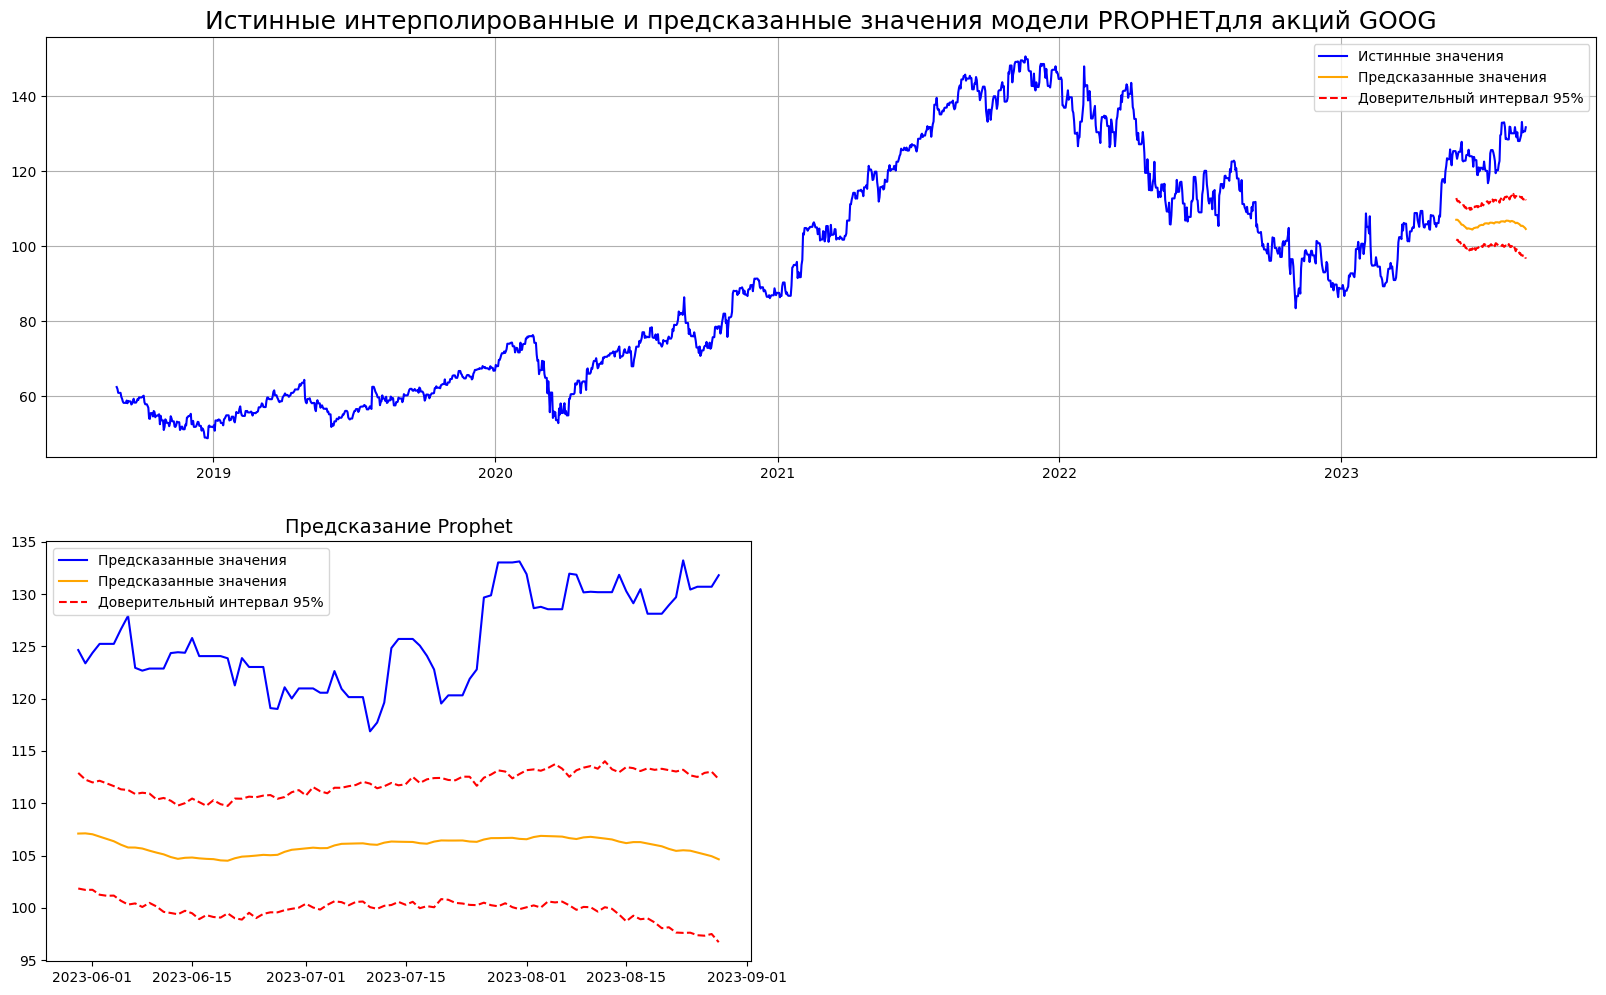

In [40]:
get_plot_time_series_predicted(
    pred_prophet_fit, test_df, 
    f"Истинные интерполированные и предсказанные значения модели PROPHET" \
        f"для акций {pred_model_ARIMA_fit.columns[1]}", 
    'Предсказание Prophet'
)

Визуализируем предсказание встроенными средствами библиотеки Prophet:

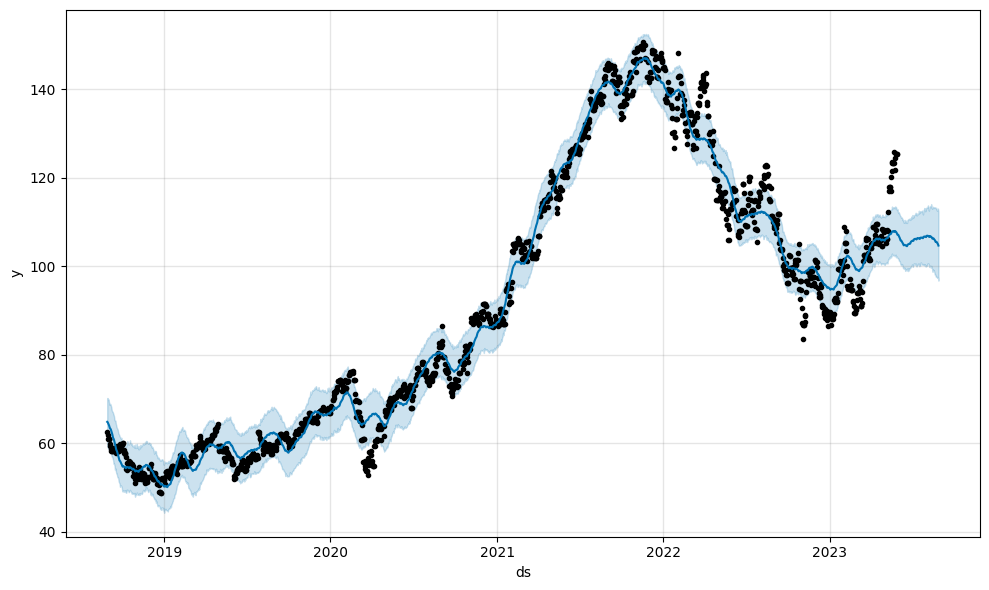

In [41]:
# визуализация прогноза
prophet_model.plot(forecast);

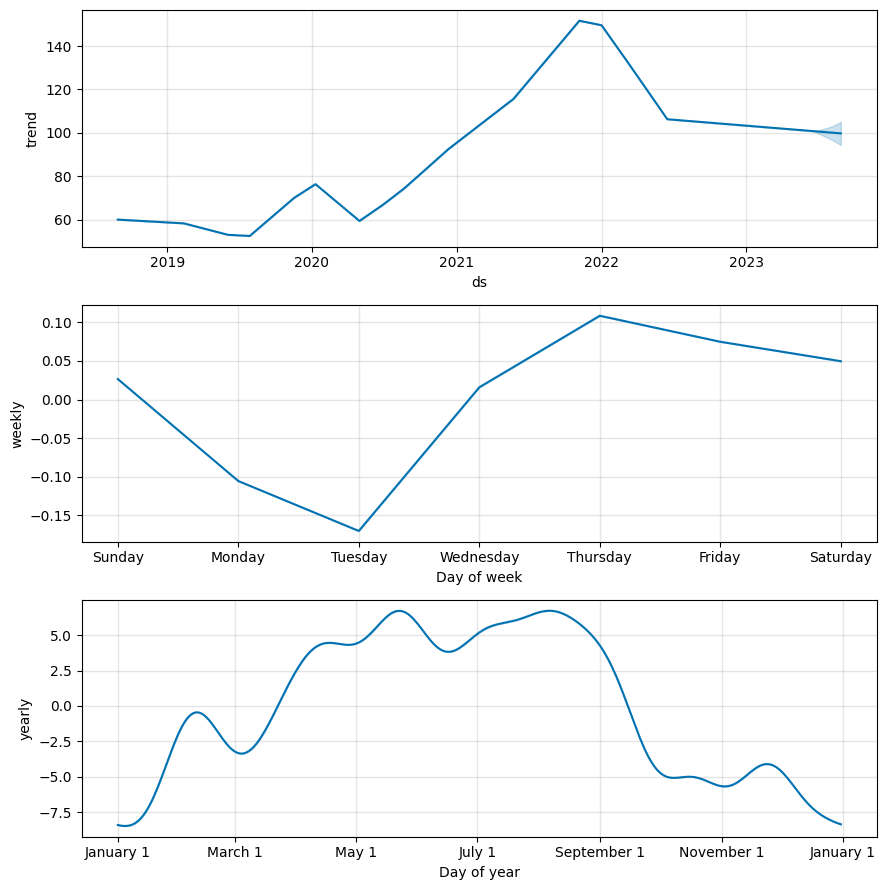

In [42]:
# визуализация трендов
prophet_model.plot_components(forecast);

Визуально, всё очень здорово, но посмотрим на метрики:

In [43]:
# get_metrics(test_prophet[test_prophet.columns[1]].values, predicted, train_prophet[train_prophet.columns[1]].values)
get_metrics(test_df.values, test_forecast['yhat'])

MAPE: 15.52 %
MSE: 4.01551e+02 $^2
RMSE: 2.00387e+01 $


### **Выводы:**

На первый взгляд, визуально, модель неплохо подстроилась под данные, но метрики говорят об обратном - некоторый "откат" назад, даже, хуже *baseline*-решения. Видно, что предсказание модели **Prophet** не уловило тенденцию. Объяснить это можно тем, что **Prophet** лучше всего работает с временными рядами, которые имеют сильные сезонные эффекты, что является не нашим случаем.

---

## 3.5 Ансамблевая модель

Попробуем каскадную ансаблевую голосующую модель. Главная (родительская) голосующая модель будет состоять из 4 дочерних:

* *LinearRegression*,
* *AdaBoostRegressor*, 
* *RandomForestRegressor*, 
* *GradientBoostingRegressor*.

Все будет вычисляться на кросс-валидации *TimeSeriesSplit*.

Ну что ж, поехали:

In [44]:
# формируем тренировочную и тестовую выборки
X_train = pd.DataFrame(range(data[data.columns[0]].shape[0]))[:train_df.shape[0]]
X_test = pd.DataFrame(range(data[data.columns[0]].shape[0]))[train_df.shape[0]:]
y_train = train_df[train_df.columns[0]]
y_test = test_df[test_df.columns[0]]

In [47]:
# задаём объект класса TimeSeriesSplit для сплитования time series
TSS = model_selection.TimeSeriesSplit(n_splits=CV_FOLDS, test_size=3)

# задаём объект класса LinearRegression
LR = linear_model.LinearRegression(n_jobs=CPU_ALL)

# задаём объект класса AdaBoostRegressor
ADA = ensemble.AdaBoostRegressor(random_state=RANDOM_SEED_42)

# задаём объект класса RandomForestRegressor
RFR = ensemble.RandomForestRegressor(
    n_jobs=CPU_ALL, 
    random_state=RANDOM_SEED_42,
    warm_start=True
)

# задаём объект класса GradientBoostingRegressor
GBR = ensemble.GradientBoostingRegressor(
    random_state=RANDOM_SEED_42,
    warm_start=True
)

# задаём голосующий ансамбль VotingRegressor
VR = ensemble.VotingRegressor(
    estimators=[('lr', LR), ('ada', ADA), ('rf', RFR), ('gbr', GBR)], 
    n_jobs=CPU_ALL
)

# обучаем модель VotingRegressor и предсказание на тестовой выборке
VR.fit(X_train, y_train)

score = model_selection.cross_val_score(
    VR,
    X_train, y_train,
    scoring='neg_mean_squared_error',
    cv=TSS, 
    n_jobs=CPU_ALL
).mean()
print(f'MSE на кросс-валидации: {-score:.{TOL}f}')

# вычисляем предсказание
pred_VR_test = VR.predict(X_test)

VotingRegressor(estimators=[('lr', LinearRegression(n_jobs=-1)),
                            ('ada', AdaBoostRegressor(random_state=42)),
                            ('rf',
                             RandomForestRegressor(n_jobs=-1, random_state=42,
                                                   warm_start=True)),
                            ('gbr',
                             GradientBoostingRegressor(random_state=42,
                                                       warm_start=True))],
                n_jobs=-1)

MSE на кросс-валидации: 8.71840


Оцениваем метрики:

In [48]:
get_metrics(test_df, pred_VR_test)

MAPE: 2.83 %
MSE: 1.69582e+01 $^2
RMSE: 4.11803e+00 $


### **Выводы:**

Метрики хороши, лучше *baseline*-решения, лучше модели **Prophet**. Объяснить это можно тем, что **Prophet** лучше всего работает с временными рядами, которые имеют сильные сезонные эффекты, что является не нашим случаем. Каскад из 4 моделей хорош, но недостаточно, всё-таки уступает SARIMA.

---

## 3.6 Модель CatBoostRegressor

Попробуем раскрыть силу **CatBoost**. Будем использовать все доступные мощности видеокарты и кросс-валидацию на временных рядах *TimeSeriesSplit*.

Для облегчения работы обернём все в *GridSearchCV*:

In [51]:
# создаём объект класса CatBoostRegressor, обучаем модель
CBR = cb.CatBoostRegressor(
    random_state=RANDOM_SEED_42, 
    task_type="GPU",        # используем GPU
    devices='0:1',          # используем все видеокарты
    verbose=100,            # вывести лог каждые 100 итераций
)

In [52]:
# задаём объект класса GridSearchCV с кросс-валидацией TimeSeriesSplit, обучаем модель
GSCV_CBR = model_selection.GridSearchCV(
    estimator=CBR, 
    param_grid={'iterations': [999]}, 
    scoring='neg_mean_squared_error', 
    n_jobs=CPU_ALL, 
    cv=TSS, 
    verbose=1
)

# обучаем модель, ищем оптимальный гиперпараметр
GSCV_CBR.fit(X_train, y_train)

# вычисляем предсказание GridSearchCV с CatBoostRegressor на тестовой выборке
pred_GSCV_CBR_test = GSCV_CBR.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Learning rate set to 0.043443
0:	learn: 28.7735820	total: 14.3ms	remaining: 14.3s
100:	learn: 3.3223704	total: 914ms	remaining: 8.12s
200:	learn: 2.9752239	total: 1.87s	remaining: 7.41s
300:	learn: 2.9751554	total: 2.65s	remaining: 6.15s
400:	learn: 2.9661375	total: 3.42s	remaining: 5.1s
500:	learn: 2.9661374	total: 4.05s	remaining: 4.02s
600:	learn: 2.8704965	total: 4.87s	remaining: 3.23s
700:	learn: 2.7459707	total: 5.77s	remaining: 2.45s
800:	learn: 2.6727954	total: 6.57s	remaining: 1.63s
900:	learn: 2.5959000	total: 7.66s	remaining: 833ms
998:	learn: 2.5499879	total: 8.7s	remaining: 0us


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=3),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000023F518E4400>,
             n_jobs=-1, param_grid={'iterations': [999]},
             scoring='neg_mean_squared_error', verbose=1)

Оценим модель:

In [53]:
get_metrics(test_df, pred_GSCV_CBR_test)

MAPE: 2.97 %
MSE: 2.17893e+01 $^2
RMSE: 4.66790e+00 $


### **Выводы:**

Несмотря на всю мощь, метрики говорят о хороших показателях. Метрики чуть-чуть уступают каскадному решению VotingRegressor, можно сказать, идут вровень, лучше модели **Prophet**. **CatBoostRegressor** не смогла уловить сезонные эффекты.

---

# 4. Результаты, выводы

Результаты построения и оценки моделей по всем котировкам сведены в итоговую таблицу:

<center>

| Модель \ Котировка | <font color='LightSeaGreen'>**AAPL**</font> | <font color='LightSeaGreen'>**MSFT**</font> | <font color='LightSeaGreen'>**GOOG**</font> | NVDA |
| :-: | :-: | :-: | :-: | :-: |
| **SMA(90) (baseline)** | MAPE: 6.33 %<br>MSE: 152.924 $\$^2$<br>RMSE: 12.366 $\$$ | MAPE: 6.08 %<br>MSE: 533.009 $\$^2$<br>RMSE: 23.087 $\$$ | MAPE: 5.84 %<br>MSE: 72.875 $\$^2$<br>RMSE: 8.537 $\$$ | MAPE: 17.20 %<br>MSE: 6514.13 $\$^2$<br>RMSE: 80.710 $\$$ |
| <font color='Tomato'>**SARIMA<br>(auto_arima)**</font> | SARIMAX(0, 1, 1)x(10, 1, 0, 5)<br>AIC - 7376.590<br> | SARIMAX(2, 1, 1)x(10, 1, 1, 5)<br>AIC - 9399.147 | SARIMAX(0, 1, 1)x(10, 1, 0, 5)<br>AIC - 6622.038 | SARIMAX(2, 1, 0)x(10, 1, 0, 5)<br>AIC - 10364.486 |
| <font color='LightSeaGreen'>**SARIMA(1, 1, 1)x(1, 1, 1, 5)**</font> | AIC - 7238.361<br>MAPE: 4.53 %<br>MSE: 98.261 $\$^2$<br>RMSE: 9.913 $\$$ | AIC - 9251.928<br>MAPE: 2.89 %<br>MSE: 164.325 $\$^2$<br>RMSE: 12.819 $\$$ | <font color='LightSeaGreen'>**AIC - 6474.312<br>MAPE: 2.67 %<br>MSE: 16.393 $\$^2$<br>RMSE: 4.049 $\$$**</font> | AIC - 10233.636<br>MAPE - 7.90 %<br>MSE - 1645.49 $\$^2$<br>RMSE - 40.565 $\$$ |
| <font color='Tomato'>**Prophet**</font> | MAPE: 7.68 %<br>MSE: 256.441 $\$^2$<br>RMSE: 16.014 $\$$ | MAPE: 7.27 %<br>MSE: 734.196 $\$^2$<br>RMSE: 27.096 $\$$ | MAPE: 15.52 %<br>MSE: 401.551 $\$^2$<br>RMSE: 20.039 $\$$ | MAPE - 29.86 %<br>MSE - 17547.0 $\$^2$<br>RMSE - 132.465 $\$$ |
| **Ансамбль<br>VotingRegressor + TimeSeriesSplit** | MAPE: 7.49 %<br>MSE: 243.376 $\$^2$<br>RMSE: 15.601 $\$$ | MAPE: 3.38 %<br>MSE: 188.141 $\$^2$<br>RMSE: 13.716 $\$$ | MAPE: 2.83 %<br>MSE: 16.958 $\$^2$<br>RMSE: 4.118 $\$$ | MAPE - 17.47 %<br>MSE - 6480.24 $\$^2$<br>RMSE - 80.500 $\$$ |
| **GridSearchCV<br>CatBoostRegressor + TimeSeriesSplit** | MAPE: 6.43 %<br>MSE: 1.90320e+02 $\$^2$<br>RMSE: 1.37956e+01 $\$$ | MAPE: 3.85 %<br>MSE: 243.680 $\$^2$<br>RMSE: 15.610 $\$$ | MAPE: 2.97 %<br>MSE: 21.789 $\$^2$<br>RMSE: 4.668 $\$$ | MAPE - 22.12 %<br>MSE - 9984.72 $\$^2$<br>RMSE - 99.924 $\$$ |

</center>

### **Выводы:**

* Только модель SARIMA показала результаты, соответствующие ожиданиям - наилучшие.

* Автоматический подбор гиперпараметров показал себя не очень удачно, на всех котировках просадка по метрике - AIC.

* Модель Prophet не смогла показать хороший результат ни на одной котировке, тут может быть как неучтённая моделью сезонность, так и возможные пробелы в исследовании.

* Каскадный ансамбль из 4 моделей, в целом, показал себя лучше CatBoost.

---

# 5. Вывод в продакшн

## 5.1 Подготовка модели к продакшену

In [55]:
# сериализуем pipeline и записываем результат в файл
with open('../microservice/model/arima.pkl', 'wb') as output:
    pickle.dump(model_ARIMA_fit, output)

## 5.2 Dockerfile

Структура каталогов микросервиса:

```py
PROJECT_final
    └─microservice
        ├─app
        |   ├─model
        |   |   └─arima.pkl
        |   └─server.py
        ├─project_final_venv\
        ├─Dockerfile
        ├─requirements.txt
        └─uwsgi.ini
```

Содержание `Dockerfile`:

```py
FROM tiangolo/uwsgi-nginx-flask:python3.10
COPY ./app/ ./
COPY ./requirements.txt ./
COPY ./uwsgi.ini ./
RUN pip install --no-cache-dir -r requirements.txt
CMD [ "python", "./server.py" ]
```

## 5.3 Сборка и запуск сервиса

Для сборки контейнера пишем в консоли:

In [ ]:
# $ docker build -t server_image .

Для запуска контейнера как сервис пишем в консоли:

In [ ]:
# $ docker run -it -d --rm -p 5000:5000 --name server_container server_image

## 5.4 Получение предсказания

Для получения предсказания на будущую дату (по умолчанию) в браузере в адресной строке вводим:

In [ ]:
# http://127.0.0.1:5000/predict

Для получения предсказания на произвольную дату в браузере в адресной строке вводим, например, дата 2023-09-20:

In [ ]:
# http://127.0.0.1:5000/predict?date=2023-09-20